In [1]:
import tensorflow as tf
import tensorlayer as tl
import numpy as np

import os
from sklearn.model_selection import train_test_split

In [16]:
from scipy.misc import imread
import matplotlib.pyplot as plt  # dealing with plots 
import tqdm

In [3]:
# Helper function to load images information (image_path, image_label)
def load_image_path(data_path, valid_proportion, test_proportion):
    pos_image_path = []
    pos_labels = []

    neg_image_path = []
    neg_labels = []

    ful_image_path = []
    ful_labels = []

    np.random.seed(0)

    pos_path = data_path + "1/"
    for img in tf.gfile.ListDirectory(pos_path):
        # if '.bmp' not in img:
        #    continue

        label = 1

        path = os.path.join(pos_path, img)
        pos_image_path.append(path)
        pos_labels.append(label)

    neg_path = data_path + "0/"
    for img in tf.gfile.ListDirectory(neg_path):
        # if '.bmp' not in img:
        #    continue

        label = 0

        path = os.path.join(neg_path, img)
        neg_image_path.append(path)
        neg_labels.append(label)

    ful_image_path = pos_image_path + neg_image_path
    ful_labels = pos_labels + neg_labels

    temp = np.array([ful_image_path, ful_labels])
    temp = temp.transpose()
    np.random.shuffle(temp)
    ful_image_path = list(temp[:, 0])
    ful_labels = list(temp[:, 1])
    ful_labels = [int(i) for i in ful_labels]

    x_train, x_valid, y_train, y_valid = train_test_split(ful_image_path, ful_labels,
                                                          test_size=(valid_proportion + test_proportion),
                                                          stratify=ful_labels, random_state=1)
    x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=test_proportion / (
            valid_proportion + test_proportion), stratify=y_valid, random_state=1)

    print("train_num: %d ,pos_num: %d , neg_num: %d" % (
        len(y_train), count_pos(y_train), len(y_train) - count_pos(y_train)))
    print("valid_num: %d ,pos_num: %d , neg_num: %d" % (
        len(y_valid), count_pos(y_valid), len(y_valid) - count_pos(y_valid)))
    print("test_num : %d ,pos_num: %d , neg_num: %d" % (
        len(y_test), count_pos(y_test), len(y_test) - count_pos(y_test)))

    return x_train, y_train, x_valid, y_valid, x_test, y_test


def count_pos(lables):
    num = 0
    for i in range(len(lables)):
        if lables[i] == 1:
            num = num + 1
    return num

In [4]:
Train_Proportion = 0.8  # Proportion of the data to be used for training
Valid_Proportion = 0.1
Test_Proportion = 0.1  #
data_dir = "F:/Github/clone/image_food_classification/datasets/food_101_dataset/"

In [5]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_image_path(data_dir, Valid_Proportion,Test_Proportion)

train_num: 3593 ,pos_num: 757 , neg_num: 2836
valid_num: 449 ,pos_num: 95 , neg_num: 354
test_num : 450 ,pos_num: 95 , neg_num: 355


In [19]:
def write_tfrecord(images_path, labels, filename):
    """
    Args:
        images_path : list type
        labels : list type
        filename : string, 生成的tfrecord文件的存放路径
    """
    #if os.path.isfile(filename):
    if tf.gfile.Exists(filename):
        print("%s exists" % filename)
#         os.remove(filename)
        return

    print("Converting data into %s ..." % filename)    
    with tf.Session() as sess:
        
        writer = tf.python_io.TFRecordWriter(filename)
        for index, img in enumerate(images_path):
            image = imread(img)
            
            img_w = int(image.shape[0])
            img_h = int(image.shape[1])
            label = int(labels[index])            
            img_raw = image.tostring()#tobytes()
            
            example = tf.train.Example(features=tf.train.Features(feature={
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
                "img_w": tf.train.Feature(int64_list=tf.train.Int64List(value=[img_w])),
                "img_h": tf.train.Feature(int64_list=tf.train.Int64List(value=[img_h])),
                'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
            }))
            writer.write(example.SerializeToString())  # Serialize To String
        writer.close()
    print("done")

In [6]:
def read_tfrecord(filename, is_train=None):
    """
    Args:        
        is_train : True or False or None
        filename : string, 读取的tfrecord文件的存放路径
    Returns:
        img : 3D tensor [width, height, 3], dtype=tf.uint8
        label : 0D tensor , dtype=tf.int32        
    """
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_w': tf.FixedLenFeature([], tf.int64),
                                           'img_h': tf.FixedLenFeature([], tf.int64),
                                           'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })
    # You can do more image distortion here for training data
    img = tf.decode_raw(features['img_raw'], tf.uint8)#这个数据类型比较重要。如果要显示的就要用uint8
    img_w = tf.cast(features['img_w'], tf.int32)
    img_h = tf.cast(features['img_h'], tf.int32)    
    
    img = tf.reshape(img, [img_w, img_h, 3])
    label = tf.cast(features['label'], tf.int32)
    
    if is_train == True:
        # 1. Randomly crop a [height, width] section of the image.
        img = tf.random_crop(img, [24, 24, 3])
        # 2. Randomly flip the image horizontally.
        img = tf.image.random_flip_left_right(img)
        # 3. Randomly change brightness.
        img = tf.image.random_brightness(img, max_delta=63)
        # 4. Randomly change contrast.
        img = tf.image.random_contrast(img, lower=0.2, upper=1.8)
        # 5. Subtract off the mean and divide by the variance of the pixels.
        try: # TF 0.12+
            img = tf.image.per_image_standardization(img)
        except: # earlier TF versions
            img = tf.image.per_image_whitening(img)

    elif is_train == False:
        # 1. Crop the central [height, width] of the image.
        img = tf.image.resize_image_with_crop_or_pad(img, 24, 24)
        # 2. Subtract off the mean and divide by the variance of the pixels.
        try: # TF 0.12+
            img = tf.image.per_image_standardization(img)
        except: # earlier TF versions
            img = tf.image.per_image_whitening(img)
    elif is_train == None:
        img = img
    return img, label

In [14]:
x = x_train[:4]
y = y_train[:4]
print(x)
print(y)

['F:/Github/clone/image_food_classification/datasets/food_101_dataset/1/sushi_864.jpg', 'F:/Github/clone/image_food_classification/datasets/food_101_dataset/1/sushi_395.jpg', 'F:/Github/clone/image_food_classification/datasets/food_101_dataset/0/lobster_roll_sandwich_900.jpg', 'F:/Github/clone/image_food_classification/datasets/food_101_dataset/1/sushi_82.jpg']
[1, 1, 0, 1]


In [20]:
#在指定位置写tfrecord文件
tfrecord_path = "C:/Users/hsqyc/Desktop/hi"
write_tfrecord(x,y,tfrecord_path)

Converting data into C:/Users/hsqyc/Desktop/hi ...
done


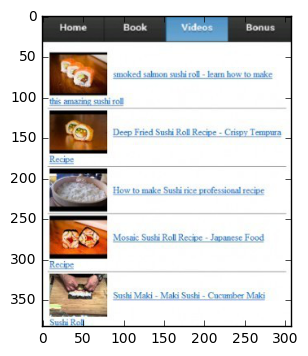

ok


In [13]:
#读取tfrecord文件并显示图片
tfrecord_path = "C:/Users/hsqyc/Desktop/hi"
C, D = read_tfrecord(tfrecord_path, None)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    E,F = sess.run([C,D])

    plt.imshow(E)
    plt.show()
        
    coord.request_stop()
    coord.join(threads)
    
    print("ok")